In [1]:
import os
import sys
import numpy as np
import scipy
import pandas as pd
import pywt as wt
import matplotlib.pyplot as plt
# For lag plot
from pandas.plotting import lag_plot
# For ACF
import statsmodels
from statsmodels.tsa.stattools import acf
# For zoom-in inside the plot box
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
# Gridspec
import matplotlib.gridspec as gridspec
%matplotlib notebook

### Importing data, using Kepler light curves

Import a random Kepler light curve. Time is in days, flux is a relative scale.

In [2]:
lc_x = pd.read_csv('DataV_koi_kplr005706966.csv', names=['time', 'flux', 'e_flux'], 
                   nrows=10500, engine='python')
npt_lsst = np.ceil(np.ptp(lc_x.time.values) / 1.6).astype('int')
lc_x2 = lc_x[::npt_lsst]
lc_x2.reset_index(drop=True, inplace=True)

Getting the sampling rate (cadence), we will need it after to scale measurements to day scales

In [3]:
cad1 = np.median(np.ediff1d(lc_x['time'].values))
cad2 = np.median(np.ediff1d(lc_x2['time'].values))
print('Kepler sampling: {0:.2f} d, LSST-like sampling:{1:.2f} d'.format(cad1, cad2))

Kepler sampling: 0.02 d, LSST-like sampling:3.04 d


Quick visualization, both Kepler sample-like and LSST sample-like (best scenario)

<IPython.core.display.Javascript object>


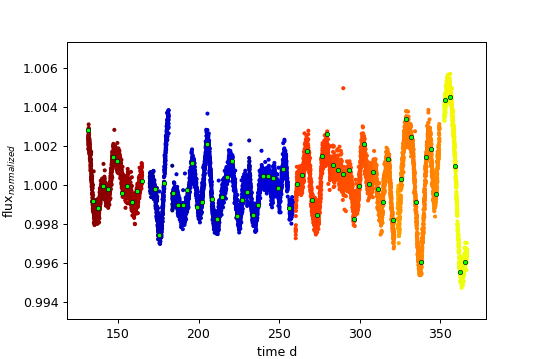

(0.99309230716598917, 1.0073411378090109)

In [4]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.scatter(lc_x.time, lc_x.flux, marker='o', s=5, c=lc_x.e_flux, cmap='jet')
ax.scatter(lc_x2.time, lc_x2.flux, marker='.', s=50, c='lime', edgecolor='k', lw=0.5)
ax.set_xlabel('time d')
ax.set_ylabel(r'flux$_{normalized}$')
ax.set_ylim([np.min(lc_x.flux) - np.std(lc_x.flux), np.max(lc_x.flux) + np.std(lc_x.flux)])

Quick checking: lag plot should be random for structures with no memory. The correlation here is a sanity check

<IPython.core.display.Javascript object>


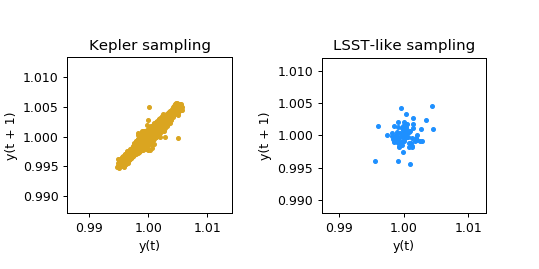

In [5]:
plt.close('all')
fig, ax = plt.subplots(1, 2, figsize=(6, 3))
lag1 = lag_plot(lc_x.flux, ax=ax[0], marker='.', c='goldenrod')
lag2 = lag_plot(lc_x2.flux, ax=ax[1], marker='.', c='dodgerblue')
#
for sub in ax:
    sub.set_aspect('equal')
ax[0].set_title('Kepler sampling')
ax[1].set_title('LSST-like sampling')
plt.subplots_adjust(wspace=0.55)

### Let's create some gaps 

### Autocorrelation Function 

$\rho_{k} = \dfrac{\sum_{i=0}^{N-k} x_{i}x_{i+k}}{\sum_{i}^{N} x_{i}}$
Where $\rho_{k}$ is the autocorrelation coefficient at lag *k*. Each lag *k* corresponds to $\tau_{k}=k\,\Delta t$, $\Delta t$ being the cadence.

It is safe to only look for periods shorter than half the light curve, $k \leq \frac{N}{2}$

Calculate the autocorrelation coefficients via statsmodels. Note that the `tsa.stattools.acf` method receives only the flux, thus assuming the spacing between each observation is uniform.

In [6]:
acf_coeffs = acf(lc_x.flux.values, unbiased=False, nlags=len(lc_x.flux.values) // 2)
tau_k = np.arange(1, acf_coeffs.size + 1, 1)
t_d = cad1 * tau_k 
#
print('Number of coefficients from the ACF calculation is: {0}'.format(acf_coeffs.size))

Number of coefficients from the ACF calculation is: 5251


<IPython.core.display.Javascript object>


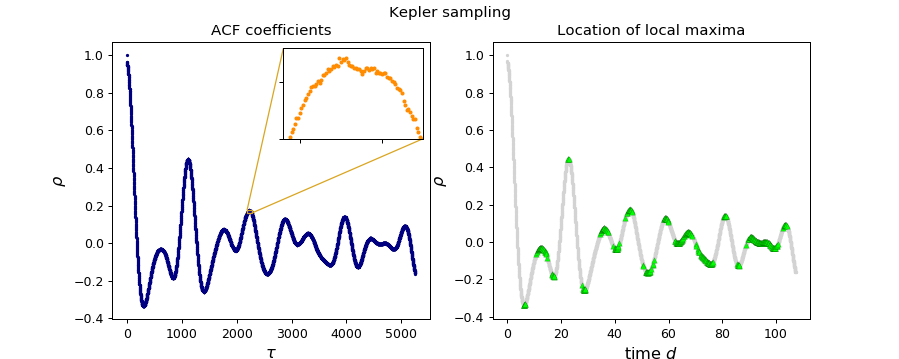

Text(0.5,0.98,'Kepler sampling')

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
# Raw results from ACF are 'coarse', because of the nature of the input data
ax[0].scatter(tau_k, acf_coeffs, marker='.', s=10, color='navy')
# Zoom in
if 1:
    zoom_factor = 30
    ax0_zoom = zoomed_inset_axes(ax[0], zoom_factor, loc=1)
    ax0_zoom.scatter(tau_k, acf_coeffs, marker='.', s=20, color='darkorange')
    ax0_zoom.set_xlim(2190, 2275)
    ax0_zoom.set_ylim(0.16, 0.176)
    ## Remove tick labels
    ax0_zoom.xaxis.set_major_formatter(plt.NullFormatter())
    ax0_zoom.yaxis.set_major_formatter(plt.NullFormatter())
    mark_inset(ax[0], ax0_zoom, loc1=2, loc2=4, fc='none', ec='goldenrod')
#
# Maxima for the coefficients
aux_maxima = scipy.signal.argrelextrema(acf_coeffs, np.greater)
ax[1].scatter(t_d, acf_coeffs, marker='.', s=10, color='lightgray')
ax[1].scatter(t_d[aux_maxima], acf_coeffs[aux_maxima], marker='^', s=20, color='lime', 
              edgecolor='k', linewidths=0.1)
#
for axis in ax:
    axis.set_ylabel(r'$\rho$', fontsize=13)
ax[0].set_xlabel(r'$\tau$', fontsize=13)
ax[1].set_xlabel(r'time $d$', fontsize=13)
#
ax[0].set_title('ACF coefficients')
ax[1].set_title('Location of local maxima')
plt.suptitle('Kepler sampling')

**Smooth the ACF coefficient distribution to easyly locate the local maxima. **

In [8]:
def gaussian(mu, sigma, x):
    return np.exp(np.power(-(x - mu), 2) / (2 * np.power(sigma, 2))) / (sigma * np.sqrt(2 * np.pi))

Values for the Gaussian (convolution) are empirical, as a compromise between diminish noise and keep the ACF signal. 
Note we need to trim a bit the result array, due to border padding. Also, remember the normalization, to keep the scale.

In [9]:
sigma_x = 18 / 2.35
x = np.arange(0, 56, 1)
acf_g_conv = scipy.signal.convolve(acf_coeffs, gaussian(0, sigma_x, x)) / np.sum(gaussian(0, sigma_x, x))
print('Original size of the ACF coefficients array: {0}. The smoothed: {1}'.format(acf_coeffs.size, acf_g_conv.size))

Original size of the ACF coefficients array: 5251. The smoothed: 5306


In [10]:
# Trim the padded extra section, and re-use the previously defined inteval tau_k
Ntrim = acf_g_conv.size - acf_coeffs.size
acf_g_conv = acf_g_conv[Ntrim:]

<IPython.core.display.Javascript object>


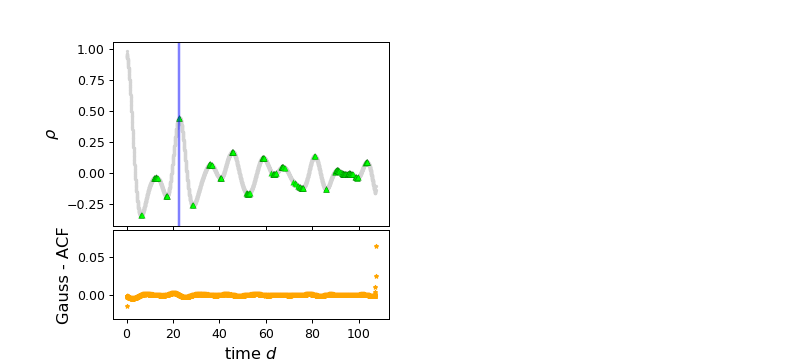

Text(0,0.5,'Gauss - ACF')

In [11]:
# Grid
fig = plt.figure(figsize=(9, 4))
gs1 = gridspec.GridSpec(3, 3)
gs1.update(left=0.14, right=0.48, hspace=0.05)
ax0 = fig.add_subplot(gs1[: -1, :])
ax1 = fig.add_subplot(gs1[-1, :], sharex=ax0)
#
ax1.scatter(t_d, acf_g_conv - acf_coeffs, marker='*', s=10, color='orange')
# Local maxima
aux_maxima = scipy.signal.argrelextrema(acf_g_conv, np.greater)
ax0.scatter(t_d, acf_g_conv[:5251], marker='.', s=10, color='lightgray')
ax0.scatter(t_d[aux_maxima], acf_g_conv[aux_maxima], marker='^', s=20, color='lime', 
              edgecolor='k', linewidths=0.1)
# Global maxima
idx_gmax = np.argmax(acf_g_conv[aux_maxima])
ax0.axvline(t_d[aux_maxima][idx_gmax], lw=2, c='b', alpha=0.5)
#
ax0.set_ylabel(r'$\rho$', fontsize=13)
ax1.set_xlabel(r'time $d$', fontsize=13)
ax1.set_ylabel(r'Gauss - ACF', fontsize=13)

In [14]:
max_acf_kplr = t_d[aux_maxima][np.argmax(acf_g_conv[aux_maxima])]
print('Maximum of the ACF: {0:.2f} d'.format(max_acf_kplr))

Maximum of the ACF: 22.68 d


### Let's do the same for the more sparse situation...

In [15]:
acf_coeffs_spa = acf(lc_x2.flux.values, unbiased=False, nlags=len(lc_x2.flux.values) // 2)
tau_k_spa = np.arange(1, acf_coeffs_spa.size + 1, 1)
t_d_spa = cad2 * tau_k_spa

We must remember that so far we are assuming an uniform sampling . In the case of Kepler cadence, given the amount of points, for this analysis this is not a concern.

In the case of a more sparse time series, changes in the cadence will make us result not be as accurate as if having a regular cadence.

<IPython.core.display.Javascript object>


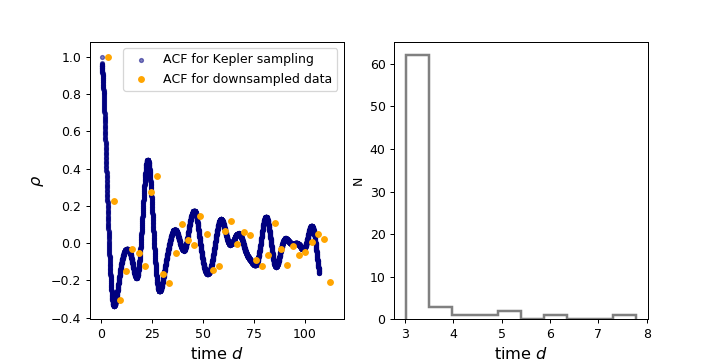

Text(0,0.5,'N')

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].scatter(t_d, acf_coeffs, alpha=0.5, label='ACF for Kepler sampling', c='navy', s=10)
ax[0].scatter(t_d_spa, acf_coeffs_spa, label='ACF for downsampled data', c='orange', s=20)
# Histogram of the cadence in the data
ax[1].hist(np.ediff1d(lc_x2['time'].values), bins=10, histtype='step', color=['gray'], lw=2)
#
ax[0].legend(loc='upper right')
ax[0].set_xlabel(r'time $d$', fontsize=13)
ax[0].set_ylabel(r'$\rho$', fontsize=13)
ax[1].set_xlabel(r'time $d$', fontsize=13)
ax[1].set_ylabel('N')

### Wavelet Transform

Continuous vs Discrete

### (Fast) Lomb-Scargle

In [ ]:
np.arange(1,10,1)